<a href="https://colab.research.google.com/github/yukyeongmin/model/blob/main/DCGAN_with_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mnist데이터를 활용하여손글씨를 만드는 GAN을 만들어 보자!
[tensorflow DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)

model을 학습시킨후 model의 학습이 진행될수록 generator가 만드는 손글씨가 어떻게 변화하는지 gif로 만들어 확인해 보겠습니다.

In [1]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [2]:
import tensorflow as tf

tf.__version__

'2.8.0'

In [24]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

parameter setting

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NZ = 100 # generator에 넣을 noise의 길이

EPOCHS = 50
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, NZ]) # noise고정을 위해

mnist dataset을 불러와서 확인차 출력

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
print("train_images.shape : ",train_images.shape)
print("min :",np.min(train_images),"max :",np.max(train_images))

train_images.shape :  (60000, 28, 28)
min : 0 max : 255


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 기존 [0, 255]이미지를 [-1, 1]로 정규화합니다.

In [8]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

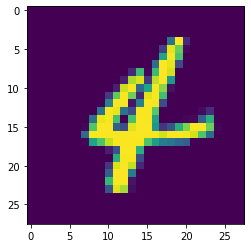

In [9]:
# 데이터셋 확인
sample= next(iter(train_dataset)) # BATCH_SIZE, 28, 28, 1
plt.imshow(sample[0][:,:,0])

### GAN을 만들어 보자. 

GAN은 discriminator와 generator 2개의 모델로 이루어진 adversarial network이다.
discriminator는 generator가 생성해낸 데이터와 DB에 있는 데이터를 구분하는 것이고,
generator의 목적은 discriminator가 구분하지 못할 정도의 데이터를 생성하는 것이다.

In [10]:
# Generator
# : 시드값(랜덤한 잡음)을 입력받아 이미지를 생성하는 모델

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NZ,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


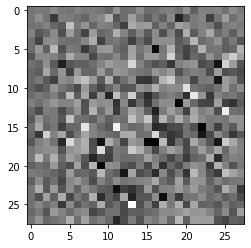

In [11]:
# make_generator_model이 제대로 동작하는지 확인

generator = make_generator_model()

noise = tf.random.normal([1, NZ])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

위의 이미지는 훈련되기 전 생성자가 만들어낸 이미지 이다.

In [12]:
# Discriminator
# : input image가 진짜인지 가짜(generator가 만든 이미지)인지 판별한다.
# 진짜라면 1, 가짜라면 -1을 출력하도록 훈련할 것이다.
# binary classifier라고 생각하면 된다.

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
# 앞서 훈련하지 않은 generator로 생성한 이미지를 discrimiantor에 넣어보자
# discriminator도 훈련하지 않았으므로 지금의 결과는 discriminator가 찍었다고 해석하면 된다
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00185545]], shape=(1, 1), dtype=float32)


### loss function과 optimizer를 정의하자

discriminator는 real, fake만 구분하므로 binary cross entropy를 loss로 사용하면 될것이다. 하지만 그것이 전부는 아니고, disctriminator 입장에서는 real_loss와 fake_loss를 모두 낮추는 것이 목표인데 반해, generator 입장에서는 fake_loss를 높이는 것이 목표이다. 

discriminator와 generator는 각각 따로 훈련되기 때문에 optimizer도 따로 설정해주어야 한다.


In [14]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

특정 숫자의 손글씨를 만들어 내는 GAN을 학습하자

### gif를 만들기 위한 check point저장

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 훈련을 위한 setting


In [17]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NZ])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.title("epoch :"+str(epoch))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### 모델 훈련

다음의 훈련과정에서는 discrimiantor 1번, generator 1번 훈련을 진행하지만, 사실 적대신경망 GAN을 학습하는 것은 까다롭습니다.
왜냐하면 한쪽의 성능이 다른 한쪽에 비해 매우 우세해지면, loss가 saturate되기 때문입니다.

ex. discriminator의 성능이 매우 좋다면, generator가 만든 이미지가 전에 비해 나아진다고 하더라도 나아졌다고 피드백을 해주지 못한다.

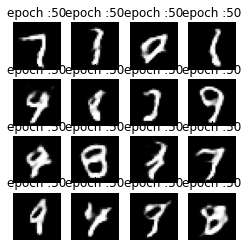

CPU times: user 4min 37s, sys: 39.8 s, total: 5min 16s
Wall time: 22min 34s


In [28]:
%%time
train(train_dataset, EPOCHS)

In [29]:
# 체크포인트 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

In [30]:
# train 과정에서 매 epoch마다 생성한 이미지를 저장해놓았는데
# epoch을 선택하면 해당 epoch에서 저장한 이미지를 보여준다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

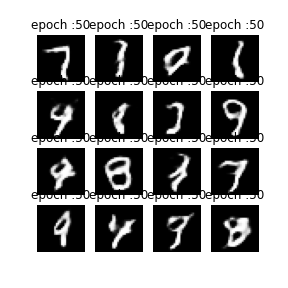

In [31]:
# 특정 epoch에서 generator가 생성한 이미지
display_image(50)

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [33]:
# colab에 저장된 gif파일 컴퓨터로 다운로드
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>